# Scott Andersen - API_hw - Part 2

In [166]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [167]:
# Set the random seed for resutls reproducibility (for testing purposes only)
np.random.seed(42)

In [168]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = 'PKJQI8S3KRE4YRDLRM2U'
alpaca_secret_key = 'BnlDGVWNTHKzkLB7tzChxSe62w0NSoFVbaiEiMou'

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [192]:
# Subset your tickers, then pull returns data:
# Set the ticker
ticker = ["SPY", "AGG"]

# Set timeframe to ''
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for SPY and AGG
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Drop unnecessary columns
df = df.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)

In [170]:
 # Display sample data
df.head()

,AGG,SPY
,close,close
time,,
2019-01-02 00:00:00-05:00,106.585,249.89
2019-01-03 00:00:00-05:00,107.020,244.46
2019-01-04 00:00:00-05:00,106.695,252.41
2019-01-07 00:00:00-05:00,106.470,254.40
2019-01-08 00:00:00-05:00,106.420,256.65


In [171]:
 # Calculate the daily roi for the stocks
daily_returns = df.pct_change()

# Display sample data
daily_returns.dropna(inplace=True)


In [172]:
daily_returns.head()

,AGG,SPY
,close,close
time,,
2019-01-03 00:00:00-05:00,0.004081,-0.021730
2019-01-04 00:00:00-05:00,-0.003037,0.032521
2019-01-07 00:00:00-05:00,-0.002109,0.007884
2019-01-08 00:00:00-05:00,-0.000470,0.008844
2019-01-09 00:00:00-05:00,0.000564,0.004130


In [173]:
 # Compute daily volatility
volatility = daily_returns.std() * np.sqrt(252)

In [174]:
 # Save the last day's closing price
daily_returns.tail()

,AGG,SPY
,close,close
time,,
2019-12-24 00:00:00-05:00,0.001292,0.000125
2019-12-26 00:00:00-05:00,0.000934,0.005136
2019-12-27 00:00:00-05:00,0.001245,-0.000155
2019-12-30 00:00:00-05:00,0.000089,-0.005451
2019-12-31 00:00:00-05:00,-0.002308,0.002554


In [175]:
# Setup the Monte Carlo Parameters

number_simulations = 500
number_records = 252 * 30
monte_carlo = pd.DataFrame(daily_returns)

In [193]:
avg_daily_return_spy = daily_returns.mean()['SPY']['close']
avg_daily_return_agg = daily_returns.mean()['AGG']['close']

print(f"The mean daily return of SPY is {avg_daily_return_spy}.")
print(f"The mean daily return of AGG is {avg_daily_return_agg}.")

The mean daily return of SPY is 0.0010401250682146959.
The mean daily return of AGG is 0.00021277231473764173.


In [194]:
# Use the `std` function to calculate the standard deviation of daily returns for `TSLA` and `SPHD`, respectively
std_dev_daily_return_agg = daily_returns.std()['AGG']['close']
std_dev_daily_return_spy = daily_returns.std()['SPY']['close']
std_dev_daily_return_spy

0.007820053413439366

In [195]:
# Set last closing prices 
agg_last_price = df['AGG']['close'][-1]
spy_last_price = df['SPY']['close'][-1]


In [196]:
# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

In [200]:
for n in range(num_simulations):

    # Initialize the simulated prices list with the last closing price of `TSLA` and `SPHD`
    simulated_agg_prices = [agg_last_price]
    simulated_spy_prices = [spy_last_price]
    
    # Simulate the returns for 252 * 30 years
    for i in range(num_trading_days):
        
        # Calculate the simulated price using the last price within the list
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return_agg, std_dev_daily_return_agg))
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))
        
        # Append the simulated price to the list
        simulated_agg_prices.append(simulated_agg_price)
        simulated_spy_prices.append(simulated_spy_price)
    
    # Append the simulated prices of each simulation to DataFrame
    simulated_price_df["AGG prices"] = pd.Series(simulated_agg_prices)
    simulated_price_df["SPY prices"] = pd.Series(simulated_spy_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    
    # Append the simulated price to the list
    simulated_agg_prices.append(simulated_agg_price)
    simulated_spy_prices.append(simulated_spy_price)
    # Append the simulated prices of each simulation to DataFrame
    simulated_price_df["AGG prices"] = pd.Series(simulated_agg_prices)
    simulated_price_df["SPY prices"] = pd.Series(simulated_spy_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    
    # Set the portfolio weights (50% AGG; 50% SPY)
    weights = [0.50, 0.50]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Print records from the DataFrame
portfolio_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.005043,0.994462,1.005857,0.999872,0.999060,0.998920,1.006443,0.997158,1.002511,0.999533,...,0.995965,0.999753,1.001726,1.001594,0.997874,1.011263,0.996211,1.007652,1.002805,0.999618
2,1.007312,0.995743,1.006166,1.003918,0.994028,0.993969,1.010566,0.998497,1.001831,1.001883,...,1.001973,1.000214,0.998620,0.998881,1.002571,1.008218,0.996771,1.010978,1.009518,0.996284
3,1.006530,0.996553,1.006539,1.008286,0.993113,0.993428,1.006526,1.006112,0.995736,1.001306,...,1.006843,1.000719,0.996532,0.999362,1.003666,1.006400,0.998218,1.014218,1.015033,0.992669
4,1.010037,0.991222,1.004499,1.002610,0.991776,0.988609,1.005256,1.005534,0.994318,0.990662,...,1.012611,0.996476,0.991955,0.996931,1.000683,1.008457,1.003286,1.017684,1.010875,0.989212


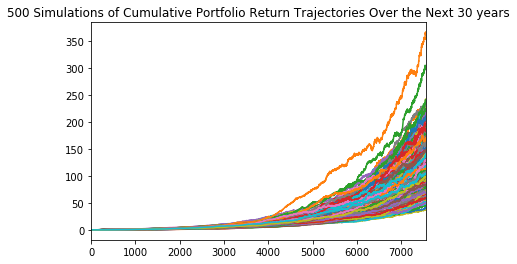

In [201]:
plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 30 years"
portfolio_cumulative_returns.plot(legend=None, title=plot_title)

In [202]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.head()

0    196.109319
1     71.206355
2    104.001915
3     96.920094
4    144.707739
Name: 7560, dtype: float64

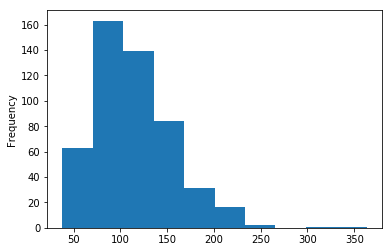

In [203]:
 # Visualize the distribution of the ending returns
ending_cumulative_returns.plot(kind='hist', bins=10)

In [204]:
# Compute cumlative returns
total_cumulative_returns = ending_cumlative_returns.iloc[-1, :]

thirtyyr_cumreturn_tenthquantile = portfolio_cumulative_returns.quantile(.1)
thirtyyr_cumreturn_fiftithquantile = portfolio_cumulative_returns.quantile(.5)
thirtyyr_cumreturn_ninetyithquantile = portfolio_cumulative_returns.quantile(.9)
print(f"10th percentile: {thirtyyr_cumreturn_tenthquantile}")
print(f"50th percentile: {thirtyyr_cumreturn_fiftithquantile}")
print(f"90th percentile: {thirtyyr_cumreturn_ninetyithquantile}")

NameError: name 'ending_cumlative_returns' is not defined

In [205]:
# Set initial investment 
initial_investment = 20000

In [188]:
#Compute expected portfolio return
proj_thirty_tenthquartile = initial_investment * thirtyyr_cumreturn_tenthquantile
proj_fiftith_tenthquartile = initial_investment * thirtyyr_cumreturn_fiftithquantile
proj_ninetyith_tenthquartile = initial_investment * thirtyyr_cumreturn_ninetyithquantile

NameError: name 'thirtyyr_cumreturn_tenthquantile' is not defined